# 1. Dependencies & Setup

In [ ]:
!pip install -q torch transformers datasets monai accelerate huggingface_hub
!mkdir -p "./checkpoints"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 19.1 MB/s eta 0:00:00


In [11]:
fetch_updated = True
# if fetch_updated:
#     !huggingface-cli login

In [12]:
from datasets import load_dataset, load_from_disk, Dataset

training_data_path = "./elwha-dataset-train.hf"
validation_data_path = "./elwha-dataset-val.hf"

if fetch_updated:
    print("Fetching data from huggingface server...")
    training_data: Dataset = load_dataset("stodoran/elwha-segmentation-tiny", split="train")  # type: ignore
    validation_data: Dataset = load_dataset("stodoran/elwha-segmentation-tiny", split="validation")  # type: ignore
    training_data.save_to_disk(training_data_path)
    validation_data.save_to_disk(validation_data_path)
else:
    print("Loading data from disk...")
    training_data = load_from_disk(training_data_path)  # type: ignore
    validation_data = load_from_disk(validation_data_path)  # type: ignore

print(training_data)
print(validation_data)

Fetchng data from huggingface server...


Saving the dataset (0/1 shards):   0%|          | 0/198 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/22 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 198
})
Dataset({
    features: ['image', 'label'],
    num_rows: 22
})


# 2. Image Prompts

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def overlay_mask(mask, ax, random_color=False, override_color=None):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    elif override_color is not None:
        color = override_color
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_control_points(coords, labels, ax, min_distance=None, min_dist_negative=None, marker_size=375):
    if len(coords) == 0 or len(labels) == 0: return
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    if min_distance is not None:
        for point in pos_points:
            circle = Circle((point[0], point[1]), min_distance, color="white", fill=False, linestyle="dashed")
            ax.add_patch(circle)

        for point in neg_points:
            _neg_distance = min_dist_negative or min_distance
            circle = Circle((point[0], point[1]), _neg_distance, color="white", fill=False, linestyle="dashed")
            ax.add_patch(circle)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker="P", s=marker_size, edgecolor="white", linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker="X", s=marker_size, edgecolor="white", linewidth=1.25)

def show_bounding_box(box, ax):
    lw = 2
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0] - lw, box[3] - box[1] - lw
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=lw))  # type: ignore

def preview_datapoint(datapoint, points=None, bbox=None, mask=True, min_distance=None, min_dist_negative=None):
    fig, axes = plt.subplots()

    axes.imshow(datapoint["image"])
    if mask: overlay_mask(np.array(datapoint["label"]), axes)
    if points: show_control_points(*points, axes, min_distance, min_dist_negative)  # type: ignore
    if bbox: show_bounding_box(bbox, axes)

    axes.axis("off")
    return fig, axes

In [14]:
# TODO: Do we need this seed here? Maybe we should seed before every __getitem__ call in the Dataset class? Maybe set the torch seed too?
np.random.seed(0)

In [15]:
from skimage.morphology import erosion
from enum import Enum

square = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1],
])

def multi_erode(im, num, element=square):
    for _ in range(num):
        im = erosion(im, element)
    return im

def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def zero_out_circle(target_mask, center, radius, inverse=False):
    rows, cols = np.ogrid[:target_mask.shape[0], :target_mask.shape[1]]
    circular_mask = (rows - center[1])**2 + (cols - center[0])**2 <= radius**2
    target_mask[circular_mask] = 1 if inverse else 0
    return target_mask

class LoggingMode(Enum):
    QUIET = 0
    NORMAL = 1
    VERBOSE = 2

In [87]:
def pick_points_in_mask(mask, number, distance=0, positive=False, existing_points=[], logging=LoggingMode.QUIET):
    target_mask = np.copy(mask)
    input_points = []

    if distance > 0:
        for point in existing_points:
            zero_out_circle(target_mask, point, distance, not positive)

    while len(input_points) < number:
        valid_indices = np.argwhere(target_mask != 0) if positive else np.argwhere(target_mask == 0)

        if len(valid_indices) == 0:
            if logging.value >= LoggingMode.NORMAL.value:
                print(f"Found only {len(input_points)} control points when {number} requested.")
                print("No valid points left.")
            break  # We have fewer than "number" points, but there are no valid points left.
        # END IF

        # TODO: Selection of point position could potentially be improved. If the point is too near
        # the edge (judged by the distance to the nearest invalid index) then try picking again.
        random_index = np.random.randint(0, len(valid_indices))
        row, col = valid_indices[random_index]
        new_point = [col, row]

        input_points.append(new_point)
        if distance > 0:
            zero_out_circle(target_mask, new_point, distance, not positive)
    # END WHILE

    return np.array(input_points)

def determine_dynamic_distance(mask, num_pts, positive=True, logging=LoggingMode.QUIET):
    one_indices = np.array(mask != 0) if positive else np.array(mask == 0)
    # ratio = one_indices.sum() / (mask.shape[0] * mask.shape[1])
    # min_distance = ratio * min(mask.shape[0], mask.shape[1])
    # min_distance = (one_indices.sum() ** 0.5) / 2

    # Works better than the above linear version to have larger min distance values compared to linear
    # for smaller ratios and to not let the min distance grow too much relative to linear for large ratios.
    min_distance = 3 * (one_indices.sum() ** 0.5) / num_pts

    if logging.value >= LoggingMode.VERBOSE.value:
        print(f"Total in mask sum is {one_indices.sum()}")
        print(f"Using dynamic distance value of {min_distance}")

    return min_distance

def determine_erosion_factor(mask, positive=True, logging=LoggingMode.QUIET):
    one_indices = np.array(mask != 0) if positive else np.array(mask == 0)
    erosion_factor = int(one_indices.sum() / 2000)

    if logging.value >= LoggingMode.VERBOSE.value:
        print(f"Total in mask sum is {one_indices.sum()}")
        print(f"Using erosion factor of {erosion_factor}")

    return erosion_factor

def generate_input_points_helper(
    input_points,
    input_labels,
    num: int,
    mask,
    positive: bool,
    dynamic_distance: bool = False,
    erode: bool = False,
    logging: LoggingMode = LoggingMode.QUIET,
):
    if dynamic_distance:
        min_distance = determine_dynamic_distance(mask, num, logging=logging, positive=positive)
    if erode:
        erosion_factor = determine_erosion_factor(mask, logging=logging, positive=positive)
        binarized = mask != 0 if positive else mask == 0

        raw_erosion = multi_erode(binarized, erosion_factor)
        if not positive:
            raw_erosion = np.logical_not(raw_erosion)
        mask = raw_erosion.astype(int)

    control_points = pick_points_in_mask(
        mask,
        num,
        distance=min_distance,
        positive=positive,
        logging=logging,
    )
    input_points.extend(control_points)
    input_labels.extend([1 if positive else 0] * len(control_points))

    if len(control_points) < num:
        pad_amnt = num - len(control_points)
        if logging.value >= LoggingMode.NORMAL.value:
            print(f"Found {len(control_points)} control points when {num} requested, padding with {pad_amnt} pad points.")

        input_points.extend([(0, 0)] * pad_amnt)
        input_labels.extend([-10] * pad_amnt)

def generate_input_points(
    number=None,
    mask=None,
    min_distance: int = 0,
    dynamic_distance=False,
    negative_src_mask=None,
    num_negative=None,
    positive_src_mask=None,
    num_positive=None,
    erode=False,
    perturbation=0,  # TODO: Implement this! Would allow points outside of the true mask.
    logging: LoggingMode = LoggingMode.QUIET,
):
    input_points = []
    input_labels = []

    generate_input_points_helper(
        input_points, 
        input_labels,
        num_positive if num_positive is not None else number,
        positive_src_mask if positive_src_mask is not None else mask,
        positive=True,
        dynamic_distance=dynamic_distance,
        erode=erode,
        logging=logging,
    )

    generate_input_points_helper(
        input_points, 
        input_labels,
        num_negative if num_negative is not None else number,
        negative_src_mask if negative_src_mask is not None else mask,
        positive=False,
        dynamic_distance=dynamic_distance,
        erode=erode,
        logging=logging,
    )

    input_points = np.array(input_points)
    input_labels = np.array(input_labels)

    return input_points, input_labels

def get_input_bbox(mask, perturbation=0):
    # Find minimum mask bounding all included mask points.
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    if perturbation:  # Add perturbation to bounding box coordinates.
        H, W = mask.shape
        x_min = max(0, x_min + np.random.randint(-perturbation, perturbation))
        x_max = min(W, x_max + np.random.randint(-perturbation, perturbation))
        y_min = max(0, y_min + np.random.randint(-perturbation, perturbation))
        y_max = min(H, y_max + np.random.randint(-perturbation, perturbation))

    bbox = [x_min, y_min, x_max, y_max]
    return bbox

# 3. Dataset & Dataloaders

TODO:
* Should we erode the mask before picking training control points, the way we do at inference time usually? Perhaps just erode less than inference time?
* Should we use a technique with erosion to find the main river portion, the subtract it from the original mask to get the smaller feeder streams? Could use this to place control points more strategically.
* Should we set the random seed every time an item is fetched from a dataset, based on index? That way control points are deterministic.

In [88]:
import ipywidgets as widgets
import cv2

datapoint_slider = widgets.IntSlider(
    value=1, min=0, max=len(training_data) - 1, step=1,
    description="Datapoint:"
)
prev_button = widgets.Button(
    description="Prev",
    tooltip="Prev",
    disabled=False,
    button_style="",
    icon="arrow-left"
)
next_button = widgets.Button(
    description="Next",
    tooltip="Next",
    disabled=False,
    button_style="",
    icon="arrow-right"
)

def change_slider_value(diff):
    next_value = datapoint_slider.value + diff
    if next_value > datapoint_slider.min and next_value < datapoint_slider.max:
        datapoint_slider.value = next_value

def incrementSliderValue(_ignore): change_slider_value(1)
def decrementSliderValue(_ignore): change_slider_value(-1)
prev_button.on_click(decrementSliderValue)
next_button.on_click(incrementSliderValue)

trigger_refresh_btn = widgets.ToggleButton(
    value=True,
    description="Randomize",
    disabled=False,
)

def handle_widgets_update(datapoint_index: int, _randomize):
    sample_datapoint = training_data[datapoint_index]
    sample_datapoint = {
        "image": cv2.resize(np.array(sample_datapoint["image"]), (256, 256)),
        "label": cv2.resize(np.array(sample_datapoint["label"]), (256, 256)),
    }

    # If you add verbose logging to these calls, the numbers should match those
    # output by dynamic_distance=True calls to generate_input_points below.
    min_distance_pos = determine_dynamic_distance(sample_datapoint["label"], 10)
    min_distance_neg = determine_dynamic_distance(sample_datapoint["label"], 5, positive=True)

    binarized = sample_datapoint["label"] != 0
    erosion_factor = determine_erosion_factor(sample_datapoint["label"])
    eroded_positive = multi_erode(binarized, erosion_factor).astype(int)

    binarized = sample_datapoint["label"] == 0
    erosion_factor = determine_erosion_factor(sample_datapoint["label"], positive=False)
    eroded_negative = multi_erode(binarized, erosion_factor).astype(int)

    points = generate_input_points(
        num_positive=10,
        num_negative=5,
        mask=sample_datapoint["label"],
        dynamic_distance=True,
        erode=True,
        logging=LoggingMode.VERBOSE
    )
    bbox = get_input_bbox(sample_datapoint["label"], perturbation=10)
    
    fig, axes = preview_datapoint(sample_datapoint, points=points, mask=True, min_distance=min_distance_pos, min_dist_negative=min_distance_neg)
    overlay_mask(eroded_positive, axes, override_color=np.array([15 / 255, 110 / 255, 255 / 255, 0.9]))
    overlay_mask(eroded_negative, axes, override_color=np.array([255 / 255, 144 / 255, 30 / 255, 0.6]))    

stepper_buttons = widgets.HBox([prev_button, next_button])
interactive_plot = widgets.interactive(
    handle_widgets_update,
    datapoint_index=datapoint_slider,
    _randomize=trigger_refresh_btn,
)
display(stepper_buttons, interactive_plot)

interactive(children=(IntSlider(value=1, description='Datapoint:', max=197), ToggleButton(value=True, descript…

In [ ]:
from torch.utils.data import Dataset

class PromptType:
    CONTROL_POINTS = "pts"
    BOUNDING_BOX = "bbox"

class SAMDataset(Dataset):
    def __init__(self, dataset, processor, prompt_type = PromptType.CONTROL_POINTS):
        self.dataset = dataset
        self.processor = processor
        self.prompt_type = prompt_type

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        datapoint = self.dataset[idx]
        input_image = cv2.resize(np.array(datapoint["image"]), (256, 256)) # This doesn't need to be 256x256 per se.
        ground_truth_mask = cv2.resize(np.array(datapoint["label"]), (256, 256)) # This needs to be 256x256 since that is the size of model outputs.

        if self.prompt_type == PromptType.CONTROL_POINTS:
            inputs = self._getitem_ctrlpts(input_image, ground_truth_mask)
        else:
            inputs = self._getitem_bbox(input_image, ground_truth_mask)

        # Add ground truth segmentation.
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

    def _getitem_ctrlpts(self, input_image, ground_truth_mask):
        # Get control points prompt.
        input_points, input_labels = generate_input_points(
            num_positive=5,
            # num_negative=10,
            mask=ground_truth_mask,
            dynamic_distance=True,
            logging=LoggingMode.QUIET,
            # logging=LoggingMode.VERBOSE,
        )
        input_points = input_points.astype(float).tolist()
        input_labels = input_labels.tolist()
        input_labels = [[x] for x in input_labels]

        # Prepare the image and prompt for the model.
        inputs = self.processor(
            input_image,
            input_points=input_points,
            input_labels=input_labels,
            return_tensors="pt"
        )

        # Remove batch dimension which the processor adds by default.
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["input_labels"] = inputs["input_labels"].squeeze(1)
        # inputs["input_points"] = inputs["input_points"].squeeze(1)

        return inputs

    def _getitem_bbox(self, input_image, ground_truth_mask):
        # Get bounding box prompt.
        bbox = get_input_bbox(ground_truth_mask, perturbation=10)

        # Prepare the image and prompt for the model.
        inputs = self.processor(input_image, input_boxes=[[bbox]], return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()} # Remove batch dimension which the processor adds by default.

        return inputs

In [ ]:
def get_model_name(model_size):
    if not (model_size == "base" or model_size == "huge"):
        raise ValueError(f'Unknown model size "{model_size}".')

    return f"facebook/sam-vit-{model_size}"

In [ ]:
from transformers import SamProcessor
from torch.utils.data import DataLoader

def get_dataloaders(model_size="base", batch_size=7, prompt_type=PromptType.BOUNDING_BOX):
    model_name = get_model_name(model_size)
    processor = SamProcessor.from_pretrained(model_name)

    train_dataset = SAMDataset(dataset=training_data, processor=processor, prompt_type=prompt_type)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    validation_dataset = SAMDataset(dataset=validation_data, processor=processor, prompt_type=prompt_type)
    validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

    return train_dataloader, validation_dataloader

# 4. Checkpoints

If uploading a `.pth` checkpoint to continue from on Google Colab, make sure to wait until it is done uploading before continuing.

In [ ]:
from transformers import SamModel
from torch.optim import Optimizer

def load_only_model(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model_size = checkpoint_path.replace("./checkpoints/", "").split("_")[0]

    model_name = get_model_name(model_size)
    model = SamModel.from_pretrained(model_name)
    model.load_state_dict(checkpoint["model_state_dict"])

    return model

def load_model_checkpoint(accelerator, checkpoint_path, model: SamModel, optimizer: Optimizer, scheduler):
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["lr_scheduler_state_dict"])

    epoch = checkpoint["epoch"] + 1  # Start from the next epoch
    best_loss = checkpoint["best_loss"]
    train_losses = checkpoint["train_losses"]
    validation_losses = checkpoint["validation_losses"]

    accelerator.print(f"Model checkpoint loaded from: {checkpoint_path}")
    accelerator.print(f"Resuming training from epoch: {epoch}")

    return model, optimizer, scheduler, epoch, best_loss, train_losses, validation_losses

def save_model_checkpoint(
        accelerator,
        checkpoint_path,
        model: SamModel,
        optimizer: Optimizer,
        scheduler,
        epoch: int,
        best_loss: float,
        train_losses,
        validation_losses,
    ):
    # accelerator.print(f"Saving checkpoint for epoch {epoch}...")
    model = accelerator.unwrap_model(model)

    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "lr_scheduler_dict": scheduler.state_dict(),
        "best_loss": best_loss,
        "train_losses": train_losses,
        "validation_losses": validation_losses,
    }
    torch.save(checkpoint, checkpoint_path)

# 5. Loss & Forward Pass

In [ ]:
import monai
import torchvision.ops as ops

dice_loss_fn = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction="mean")  # type: ignore

def sam_lc_loss(pred_mask, ground_truth):
    dice_loss = dice_loss_fn(pred_mask, ground_truth)
    focal_loss = ops.sigmoid_focal_loss(pred_mask, ground_truth, reduction="mean")
    combined_loss = (19 * focal_loss / 20) + (1 * dice_loss / 20) # Ratio based on SAM authors' findings.
    return combined_loss

loss_func = dice_loss_fn
loss_func_name = "dice"

# loss_func = sam_lc_loss
# loss_func_name = "lincomb"

In [ ]:
import torch

def calculate_loss(model: SamModel, prediction_masks: torch.Tensor, ground_truth_masks: torch.Tensor, prompt_type: PromptType, override_loss_fn = None):
    _loss_func = override_loss_fn if override_loss_fn is not None else loss_func
    if prompt_type == PromptType.CONTROL_POINTS:
        # For some reason, the output contains duplicate masks, seemingly one for each control
        # point? We can just select the the first and compute loss for that, there is no difference.
        loss = _loss_func(prediction_masks[:, 0], ground_truth_masks)
    elif prompt_type == PromptType.BOUNDING_BOX:
        loss = _loss_func(prediction_masks, ground_truth_masks)
    return loss

def forward_pass(model: SamModel, batch, prompt_type: PromptType):
    if prompt_type == PromptType.CONTROL_POINTS:
        outputs = model(
            pixel_values=batch["pixel_values"],
            input_points=batch["input_points"],
            input_labels=batch["input_labels"],
            multimask_output=False,
        )
    elif prompt_type == PromptType.BOUNDING_BOX:
        outputs = model(
            pixel_values=batch["pixel_values"],
            input_boxes=batch["input_boxes"],
            multimask_output=False,
        )
    return outputs

# 6. Train Loop

In [ ]:
import gc
from accelerate import Accelerator
from accelerate.utils import set_seed, tqdm
from torch.optim.lr_scheduler import LinearLR
from torch.optim import AdamW

def evaluate_model(model: SamModel, dataloader: DataLoader, device) -> torch.Tensor:
    model.eval()
    # losses: list[torch.Tensor] = []

    dice_losses: list[torch.Tensor] = []
    lc_losses: list[torch.Tensor] = []

    # loop = tqdm(total=len(dataloader), position=0, leave=False)
    for idx, batch in enumerate(dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad(): # Forward Pass
            outputs = forward_pass(model, batch, dataloader.dataset.prompt_type)

        # Compute Loss
        predicted_masks = outputs.pred_masks.squeeze((1, 2))
        ground_truth_masks = batch["ground_truth_mask"].float()
        # loss = calculate_loss(model, predicted_masks, ground_truth_masks, dataloader.dataset.prompt_type)
        # losses.append(loss)

        dice_losses.append(calculate_loss(model, predicted_masks, ground_truth_masks, dataloader.dataset.prompt_type, dice_loss_fn))
        lc_losses.append(calculate_loss(model, predicted_masks, ground_truth_masks, dataloader.dataset.prompt_type, sam_lc_loss))

        # Update Progress Bar
        # loop.set_description(f"Eval Loss: {loss.item():.4f}")
        # loop.update(1)
    # END FOR

    # Avoid Memory Overload
    gc.collect()
    torch.cuda.empty_cache()
    # TODO: Do we need this? Is this the right place for this?

    # return sum(losses) / len(losses)  # type: ignore
    return sum(dice_losses) / len(dice_losses), sum(lc_losses) / len(lc_losses)

def training_loop(
        model_size="base",
        learning_rate:float=1e-5,
        weight_decay:float=1e-5,
        batch_size:int=8,
        prompt_type:PromptType=PromptType.BOUNDING_BOX,
        num_epochs=300,
        mixed_precision="fp16",
        seed:int=42,
        load_checkpoint=False,
    ):
    global model, optimizer_name, checkpoint_path, train_losses, validation_losses

    set_seed(seed)
    accelerator = Accelerator(mixed_precision=mixed_precision)
    train_dataloader, validation_dataloader = get_dataloaders(model_size, batch_size, prompt_type)
    accelerator.print(f"Getting dataloaders for {model_size} model with batch size of {batch_size} and {prompt_type} prompts")

    # Instantiate the model here so that the seed also controls new weight initaliziations.
    model_name = get_model_name(model_size)
    model = SamModel.from_pretrained(model_name)

    optimizer_name = "AdamW"  # Make sure to change this if changing optimizer!
    optimizer = AdamW(model.mask_decoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
    accelerator.print(f"Loaded {model_name} model, using {optimizer_name} optimizer")

    # TODO: Add params for this to function header? Also verify it is working with lr_scheduler.get_last_lr()
    lr_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=10)

    # Train only the decoder.
    for name, param in model.named_parameters():
        if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
            param.requires_grad_(False)

    # Variables which needed to be loaded from checkpoint.
    epoch = 0
    best_loss = float("inf")
    train_losses = []
    validation_losses = []

    hyperparams = f"lr={learning_rate}_wd={weight_decay}_bs={batch_size}_{prompt_type}_mp={mixed_precision}"
    best_checkpoint_path = f"./checkpoints/{model_size}_{optimizer_name}_{hyperparams}.pth"
    last_checkpoint_path = f"./checkpoints/last_{model_size}_{optimizer_name}_{hyperparams}.pth"
    accelerator.print("Using save checkpoint path:", best_checkpoint_path)

    if load_checkpoint:
        model, optimizer, lr_scheduler, epoch, best_loss, train_losses, validation_losses = load_model_checkpoint(accelerator, best_checkpoint_path, model, optimizer, lr_scheduler)

    model, optimizer, train_dataloader, validation_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, validation_dataloader, lr_scheduler
    )

    # =============================== #
    # Main training loop starts here: #

    loop = tqdm(total=num_epochs, position=epoch, leave=False)
    while epoch < num_epochs:
        model.train()
        # epoch_losses = []
        # loop = tqdm(total=len(train_dataloader), position=0, leave=False)

        epoch_dice_losses = []
        epoch_lc_losses = []

        for idx, batch in enumerate(train_dataloader):
            # Forward Pass
            batch = {k: v.to(accelerator.device) for k, v in batch.items()}
            outputs = forward_pass(model, batch, prompt_type)

            # Compute Loss
            predicted_masks = outputs.pred_masks.squeeze((1, 2))
            ground_truth_masks = batch["ground_truth_mask"].float()
            loss = calculate_loss(model, predicted_masks, ground_truth_masks, prompt_type, dice_loss_fn)
            lc_loss = calculate_loss(model, predicted_masks, ground_truth_masks, prompt_type, sam_lc_loss)

            # Backward Pass & Optimizer Step
            optimizer.zero_grad()
            # accelerator.backward(lc_loss)
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()

            # epoch_losses.append(loss.item())

            epoch_dice_losses.append(loss.item())
            epoch_lc_losses.append(lc_loss.item())

            # loop.set_description(f"Train Loss: {loss.item():.4f}")
            # loop.update(1)
        # END FOR

        accelerator.wait_for_everyone()
        # local_validation_loss = evaluate_model(model, validation_dataloader, accelerator.device)
        # all_val_losses = accelerator.gather(local_validation_loss)
        # validation_loss = torch.mean(all_val_losses)
        # validation_losses.append(validation_loss.item())

        local_val_dice_loss, local_val_lc_loss = evaluate_model(model, validation_dataloader, accelerator.device)
        all_val_dice_losses = accelerator.gather(local_val_dice_loss)
        all_val_lc_losses = accelerator.gather(local_val_lc_loss)

        validation_loss = torch.mean(all_val_dice_losses)
        validation_lc_loss = torch.mean(all_val_lc_losses)
        validation_losses.append((validation_loss.item(), validation_lc_loss.item()))

        # local_mean_loss = torch.mean(torch.Tensor(epoch_losses))
        # all_mean_losses = accelerator.gather(local_mean_loss)
        # mean_loss = torch.mean(all_mean_losses)

        local_mean_loss = torch.mean(torch.Tensor(epoch_dice_losses))
        all_mean_losses = accelerator.gather(local_mean_loss)
        mean_loss = torch.mean(all_mean_losses)

        local_mean_loss = torch.mean(torch.Tensor(epoch_lc_losses))
        all_mean_losses = accelerator.gather(local_mean_loss)
        mean_lc_loss = torch.mean(all_mean_losses)

        if accelerator.is_main_process:
            if validation_loss < best_loss:
                save_model_checkpoint(
                    accelerator,
                    best_checkpoint_path,
                    model,
                    optimizer,
                    lr_scheduler,
                    epoch,
                    validation_loss,
                    train_losses,
                    validation_losses,
                )
                best_loss = validation_loss
            else:
                accelerator.print(f"Skipping checkpoint save since prev checkpoint is better: {best_loss} < {mean_loss}")
        # END IF

        loop.set_description(f"Mean Epoch Loss: {mean_loss:.4f}")
        loop.update(1)

        # accelerator.print(f"Epoch: {epoch + 1}/{num_epochs}")
        # accelerator.print(f"Mean loss: {mean_loss}")

        train_losses.append((mean_loss, mean_lc_loss))

        # train_losses.append(mean_loss)
        epoch += 1
    # END WHILE

    # Save the last checkpoint, useful for experiments to see the whole loss history.
    if accelerator.is_main_process:
        save_model_checkpoint(
            accelerator,
            last_checkpoint_path,
            model,
            optimizer,
            lr_scheduler,
            epoch,
            validation_loss,
            train_losses,
            validation_losses,
        )

# 7. Launching Training

In [ ]:
import time
from datetime import datetime, timezone, timedelta

def get_current_time():
    pst = timezone(timedelta(hours=-8), "PST")
    current_datetime = datetime.now(pst)
    return current_datetime.strftime("%H:%M %m/%d/%Y")

In [17]:
from accelerate import notebook_launcher

print(f"Training started at {get_current_time()}")

args = (
    "base", # model_size
    7e-6, # learning_rate
    2e-4, # weight_decay
    5, # batch_size (batch size per process is batch_size / num_processes)
    PromptType.CONTROL_POINTS, # prompt_type
    50, # num_epochs
    "fp16", # mixed_precision ("no" for none)
    42, # seed
    False, # load_checkpoint
)
notebook_launcher(training_loop, args, num_processes=1)
print(f"Training ended at {get_current_time()}")

Training started at 12:20 04/27/2024
Launching training on one GPU.


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Getting dataloaders for base model with batch size of 5 and pts prompts


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

Loaded facebook/sam-vit-base model, using AdamW optimizer
Using save checkpoint path: ./checkpoints/base_AdamW_lr=7e-06_wd=0.0002_bs=5_pts_mp=fp16.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Skipping checkpoint save since prev checkpoint is better: 233.8243408203125 < 245.02951049804688
Skipping checkpoint save since prev checkpoint is better: 228.9508514404297 < 240.80026245117188
Skipping checkpoint save since prev checkpoint is better: 228.9508514404297 < 241.1952362060547
Skipping checkpoint save since prev checkpoint is better: 228.9508514404297 < 240.9784698486328
Skipping checkpoint save since prev checkpoint is better: 228.48974609375 < 238.7512664794922
Skipping checkpoint save since prev checkpoint is better: 228.48974609375 < 239.12930297851562
Skipping checkpoint save since prev checkpoint is better: 228.48974609375 < 239.1855926513672
Skipping checkpoint save since prev checkpoint is better: 227.9878692626953 < 238.1719207763672
Skipping checkpoint save since prev checkpoint is better: 227.55905151367188 < 237.5880889892578
Skipping checkpoint save since prev checkpoint is better: 226.6936798095703 < 237.245361328125
Skipping checkpoint save since prev checkpo

In [18]:
model_size = args[0]
learning_rate = args[1]
weight_decay = args[2]
batch_size = args[3]
prompt_type = args[4]
mixed_precision = args[6]

def get_model_label():
    return f"model={model_size}, optim={optimizer_name}, lr={learning_rate}, wd={weight_decay}, bs={batch_size}, {mixed_precision}, {prompt_type}"

# 8. Results & Evaluation

| Model        | Optimizer | Learning Rate   | Weight Decay | Batch Size | Epochs | Prompts | Train Loss | Validation Loss |
|--------------|-----------|-----------------|--------------|------------|--------|---------|------------|-----------------|
| sam-vit-base | AdamW     | 1e-5            | 0            | 2          | 300    | points  | 220.9510   | 235.2056        |
| sam-vit-base | AdamW     | 3e-5            | 0            | 3          | 300    | points  | 220.3394   | 245.4707        |
| sam-vit-base | AdamW     | 7e-6            | 0            | 3          | 600    | points  | 220.4751   | 223.8311        |
| sam-vit-base | AdamW     | 7e-6            | 1e-4         | 4          | 300    | points  | 222.0167   | 219.9485        |
| sam-vit-base | AdamW     | 7e-6            | 1e-5         | 5          | 200    | points  | 224.3772   | 220.1452        |
| sam-vit-base | AdamW     | 7e-6            | 2e-4         | 5          | 300    | points  | 224.0496   | 223.9057        |
| sam-vit-base | AdamW     | 7e-6            | 2e-4         | 5          | 300    | bboxes  | 224.3229   | 217.7175        |
| sam-vit-huge | AdamW     | 1e-5            | 0            | 2          | 200    | points  | 221.4048   | 255.4305        |
| sam-vit-huge | AdamW     | 7e-6            | 1e-4         | 3          | 300    | points  | 225.3418   | 213.9504        |
| sam-vit-huge | AdamW     | 5e-6            | 1e-4         | 3          | 300    | bboxes  | 223.7908   | 215.4390        |

Model size sam-vit-base trained to optimize dice loss with AdamW using learning rate 7e-6, weight decay 2e-4, batch size 4, and bounding box prompts.

| Mixed Precision | Train Loss | Validation Loss |
|-----------------|------------|-----------------|
| None            | 226.0490   | 210.7232        |
| fp16            | 227.4363   | 211.2280        |


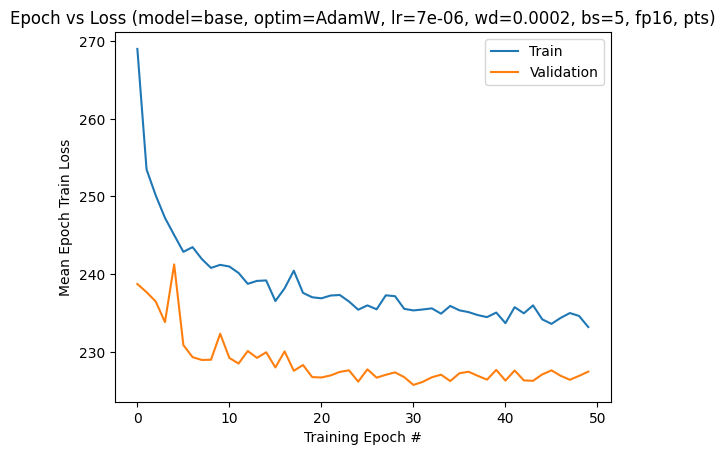

In [19]:
plt.plot([loss[0] for loss in train_losses], label="Train")
plt.plot([loss[0] for loss in validation_losses], label="Validation")

plt.title(f"Epoch vs Loss ({get_model_label()})")
plt.xlabel("Training Epoch #")
plt.ylabel("Mean Epoch Train Loss")
plt.legend();

huge_AdamW_lr=7e-06_wd=0.001_bs=3_fp16_pts -> train 223.7879, validation 215.5016

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataloader, validation_dataloader = get_dataloaders(model_size, batch_size, prompt_type)

# Evaluate performance after training:
print("Average train loss:", evaluate_model(model, train_dataloader, device))
print("\nAverage validation loss:", evaluate_model(model, validation_dataloader, device))

Average train loss: (tensor(234.0030, device='cuda:0'), tensor(11.7148, device='cuda:0'))

Average validation loss: (tensor(226.2913, device='cuda:0'), tensor(11.3379, device='cuda:0'))


In [6]:
def plot_model_comparison(paths: list[str], labels: list[str], title: str):
    if len(paths) != len(labels):
        raise Exception("Did not provide an equal number of paths and labels!")

    for idx, path in enumerate(paths):
        label = labels[idx]
        checkpoint = torch.load(path)

        train_losses = [loss[0] for loss in checkpoint["train_losses"]]
        validation_losses = [loss[0] for loss in checkpoint["validation_losses"]]

        plt.plot(train_losses, label="Train " + label, color=f"C{idx}")
        plt.plot(validation_losses, label="Validation " + label, color=f"C{idx}")

    plt.title(title)
    plt.xlabel("Training Epoch #")
    plt.ylabel("Mean Epoch Loss")
    plt.legend()

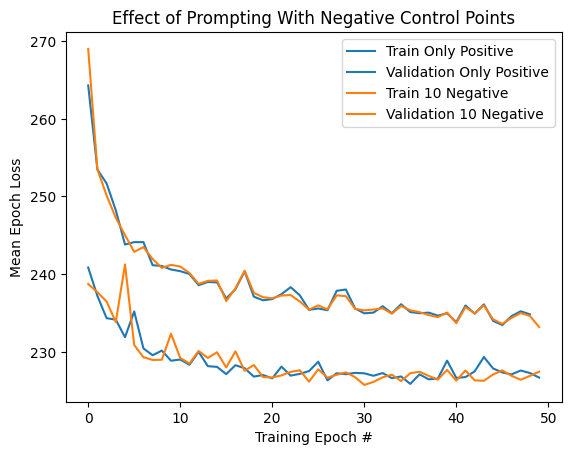

In [7]:
plot_model_comparison(
    [
        "../experiments/prompt_type/base_AdamW_lr=7e-06_wd=0.0002_bs=5_pts_mp=fp16_5p0n.pth",
        "../experiments/prompt_type/base_AdamW_lr=7e-06_wd=0.0002_bs=5_pts_mp=fp16_5p10n.pth",
    ],
    ["Only Positive", "10 Negative"],
    "Effect of Prompting With Negative Control Points"
)

In [ ]:
def visualize_prediction_quality(losses, raw_prediction, final_mask, ground_truth, input_points = None, input_labels = None, input_boxes = None):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    overlay_mask(raw_prediction, axes[0])
    overlay_mask(final_mask, axes[1])
    axes[2].imshow(ground_truth)

    for ax in axes: ax.axis("off")
    axes[0].title.set_text(f"dice_loss={losses[0]}, lc_loss={losses[1]}")

    if input_points is not None and input_labels is not None:
        show_control_points(input_points / 4, input_labels, axes[1])
        # To also display prompt overlay on the ground truth mask:
        # show_control_points(input_points / 4, input_labels, axes[2])

    if input_boxes is not None:
        show_bounding_box(input_boxes / 4, axes[1])
        # show_bounding_box(input_boxes, axes[2])

In [ ]:
def visually_evaluate_model(model: SamModel, dataloader: DataLoader, displayCount: int = float("inf")):
    model.eval()
    iterCount = 0
    loop = tqdm(total=len(dataloader), position=0, leave=False)

    for idx, batch in enumerate(dataloader):
        # Forward Pass
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = forward_pass(model, batch, prompt_type)

        outputs = outputs.pred_masks.squeeze((1, 2))
        predicted_masks = torch.sigmoid(outputs)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)

        if prompt_type == PromptType.CONTROL_POINTS:
            outputs = outputs[:, 0]
            predicted_masks = predicted_masks[:, 0]

        for batch_item in range(predicted_masks.shape[0]):
            losses = [
                dice_loss_fn(outputs[batch_item], ground_truth_masks[batch_item]),
                sam_lc_loss(outputs[batch_item], ground_truth_masks[batch_item]),
            ]

            raw_mask = predicted_masks[batch_item].cpu().numpy()
            mask = (raw_mask > 0.5).astype(np.uint8)  # TODO: Replace 0.5 with variable confidence threshold.

            if prompt_type == PromptType.CONTROL_POINTS:
                visualize_prediction_quality(
                    losses,
                    raw_mask,
                    mask,
                    batch["ground_truth_mask"][batch_item].cpu(),
                    input_points=batch["input_points"][batch_item].cpu(),
                    input_labels=batch["input_labels"][batch_item].cpu(),
                )
            elif prompt_type == PromptType.BOUNDING_BOX:
                visualize_prediction_quality(
                    losses,
                    raw_mask,
                    mask,
                    batch["ground_truth_mask"][batch_item].cpu(),
                    input_boxes=batch["input_boxes"][batch_item, 0].cpu(),
                )

        iterCount += 1
        if iterCount >= displayCount:
            break

        loop.set_description(f"Batch: {idx}")
        loop.update(1)
    # END FOR

In [ ]:
print(get_model_label())
visually_evaluate_model(model, validation_dataloader)

In [ ]:
def find_most_improved(original_model: SamModel, tuned_model: SamModel, dataloader: DataLoader, count: int = 5):
    original_model.eval()
    tuned_model.eval()

    iterCount = 0
    loop = tqdm(total=len(dataloader), position=0, leave=False)

    best_losses = [float("inf")] * count
    best_indices = [None] * count

    for idx, batch in enumerate(dataloader):
        # Forward Pass
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            original_outputs = forward_pass(original_model, batch, prompt_type)
            tuned_outputs = forward_pass(tuned_model, batch, prompt_type)

        # TODO: Below this line is unfinished.

        outputs = outputs.pred_masks.squeeze((1, 2))
        predicted_masks = torch.sigmoid(outputs)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)

        if prompt_type == PromptType.CONTROL_POINTS:
            outputs = outputs[:, 0]
            predicted_masks = predicted_masks[:, 0]

        for batch_item in range(predicted_masks.shape[0]):
            losses = [
                dice_loss_fn(outputs[batch_item], ground_truth_masks[batch_item]),
                sam_lc_loss(outputs[batch_item], ground_truth_masks[batch_item]),
            ]

            raw_mask = predicted_masks[batch_item].cpu().numpy()
            mask = (raw_mask > 0.5).astype(np.uint8)  # TODO: Replace 0.5 with variable confidence threshold.

            if prompt_type == PromptType.CONTROL_POINTS:
                visualize_prediction_quality(
                    losses,
                    raw_mask,
                    mask,
                    batch["ground_truth_mask"][batch_item].cpu(),
                    input_points=batch["input_points"][batch_item].cpu(),
                    input_labels=batch["input_labels"][batch_item].cpu(),
                )
            elif prompt_type == PromptType.BOUNDING_BOX:
                visualize_prediction_quality(
                    losses,
                    raw_mask,
                    mask,
                    batch["ground_truth_mask"][batch_item].cpu(),
                    input_boxes=batch["input_boxes"][batch_item, 0].cpu(),
                )

        iterCount += 1
        if iterCount >= displayCount:
            break

        loop.set_description(f"Batch: {idx}")
        loop.update(1)
    # END FOR